In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import math

In [2]:
class GridWorld(object):
    
    def __init__(self,p = 0.65):
        
        ### Attributes defining the Gridworld #######

        # Shape of the gridworld
        self.shape = (6,6)
        
        # Locations of the obstacles
        self.obstacle_locs = [(1,1),(2,3),(2,5),(3,1),(4,1),(4,2),(4,4)]
        
        # Locations for the absorbing states
        self.absorbing_locs = [(1,3),(4,3)]
        
        # Rewards for each of the absorbing states 
        self.special_rewards = [+10,-100] # Corresponds to each of the absorbing_locs
        
        # Reward for all the other states
        self.default_reward = -1
        
        
        # Action names
        self.action_names = ['N','E','S','W'] # Action 0 is 'N', 1 is 'E' and so on
        
        # Number of actions
        self.action_size = len(self.action_names)
        
        # Randomizing action results: [1 0 0 0] to no Noise in the action results.
        self.action_randomizing_array = [p,(1-p)/3,(1-p)/3,(1-p)/3]
        
        #Get attributes defining the world
        state_size, T, R, absorbing, locs = self.build_grid_world()
        
        #Number of valid states in the world
        self.state_size = state_size
        
        
        # Transition operator (3D tensor)
        self.T = T # T[st+1, st, a] gives the probability that action a will 
                   # transition state st to state st+1
        
        # Reward function (3D tensor)
        self.R = R # R[st+1, st, a ] gives the reward for transitioning to state
                   # st+1 from state st with action a
        
        # Absorbing states
        self.absorbing = absorbing
        
        # The locations of the valid states 
        self.locs = locs # State 0 is at the location self.locs[0] and so on
        
        # Starting location
        #TODO: randomize this
        self.starting_loc =  self.get_random_start()
        
        
        # Number of the starting state
        self.starting_state = self.loc_to_state(self.starting_loc, locs);
        
        # Locating the initial state
        self.initial = np.zeros((1,len(locs)));
        self.initial[0,self.starting_state] = 1
        
        # Placing the walls on a bitmap
        self.walls = np.zeros(self.shape);
        for ob in self.obstacle_locs:
            self.walls[ob]=1
            
        # Placing the absorbers on a grid for illustration
        self.absorbers = np.zeros(self.shape)
        for ab in self.absorbing_locs:
            self.absorbers[ab] = -1
        
        # Placing the rewarders on a grid for illustration
        self.rewarders = np.zeros(self.shape)
        for i, rew in enumerate(self.absorbing_locs):
            self.rewarders[rew] = self.special_rewards[i]
        
        #Illustrating the grid world
        self.paint_maps()
        
        
    #takes list of locations and a loc and gives the index corresponding to input loc
    def loc_to_state(self,loc,locs):
            return locs.index(tuple(loc))
    
    def get_random_start(self):
        states = [state for state in self.locs if state not in self.absorbing_locs]
        return random.choice(states)
        
    #Check if a specific location is valid and not an obstacle
    def is_location(self,loc):
        if(loc[0] < 0 or loc[1] < 0 or loc[0] > self.shape[0] - 1 or loc[1] > self.shape[1] -1):
            return False
        elif(loc in self.obstacle_locs):
            return False
        else:
            return True
        
    def get_neighbour(self, loc,direction):
        
        i = loc[0]
        j = loc[1]
        
        nr = (i-1,j)
        ea = (i,j+1)
        so = (i+1,j)
        we = (i,j-1)
        
        #If the neighbour is a valid location, accept it, otherwise, stay put
        if (direction == 'nr' and self.is_location(nr)):
            return nr
        elif (direction == 'ea' and self.is_location(ea)):
            return ea
        elif (direction == 'so' and self.is_location(so)):
            return so
        elif (direction == 'we' and self.is_location(we)):
            return we
        else:
            #Default stay where you are
            return loc
      
    ####### Getters ###########
    
    def get_transition_matrix(self):
        return self.T
    
    def get_reward_matrix(self):
        return self.R
    
    def get_valuefunction(self):
        return self.Value
    
    ########################
    
    
    
    #Returns the locations of our states, the number of their neighbours and the absorbing states
    #locations of our states: list of tuples
    #2D array: number of states x neighbours (same number if wall or blocked)
    #absorbing states: array length number of states 1 for absorbing states
    def get_topology(self):
    
        height = self.shape[0]
        width = self.shape[1]
        
        #index = 1
        locs = []
        neighbour_locs = []
        
        for i in range(height):
            for j in range(width):
                
                #Get the location of each state
                loc = (i,j)
                
                #And append if is is a valid state i.e. not absorbing
                if (self.is_location(loc)):
                    locs.append(loc)
                    
                    #Get an array with all neighbours of each state, in terms of locations
                    local_neighbours = [self.get_neighbour(loc,direction) for direction in ['nr','ea','so','we']]
                    neighbour_locs.append(local_neighbours)
                    
        #translate neighbour lists from locations to states
        num_states = len(locs)
        state_neighbours = np.zeros((num_states,4))
        
        for state in range(num_states):
            
            for direction in range(4):
                #Get neighbour location
                nloc = neighbour_locs[state][direction]
                
                #Turn location into state number 
                nstate = self.loc_to_state(nloc,locs)
                
                #Insert into neighbour matrix
                state_neighbours[state][direction] = nstate
                
        #Translate absorbing locations into state indices
        absorbing = np.zeros((1,num_states))
        for a in self.absorbing_locs:
            absorbing_statenum = self.loc_to_state(a,locs)
            absorbing[0,absorbing_statenum] = 1
        
        return locs,state_neighbours,absorbing
        
    #Builds the Grid world 
    #Return the Number of states, Transition Matrix, Reward matrix, absorbing states, and the
    #locations of all valid states
    def build_grid_world(self):
        
        locations, neighbours,absorbing = self.get_topology()
        #Get number of sttes
        S = len(locations)
        
        #Initialize the transition matrix
        T = np.zeros((S,S,4))
        
        #Fill the transition Matrix
        for action in range(4):
            for effect in range(4):
                outcome = (action+effect+1) % 4
                if outcome == 0:
                    outcome = 3
                else:
                    outcome -= 1                
                
                
                
                
                
                prob = self.action_randomizing_array[effect]
                for prior_state in range(S):
                    post_state = neighbours[prior_state,outcome]
                    post_state = int(post_state)
                    T[post_state,prior_state,action] = T[post_state,prior_state,action]+prob
                    
    
        R = self.default_reward*np.ones((S,S,4))
        for i, sr in enumerate(self.special_rewards):
            post_state = self.loc_to_state(self.absorbing_locs[i],locations)
            R[post_state,:,:] = sr
        
        
        return S,T,R,absorbing,locations
    
        ########### Internal Drawing Functions #####################

    ## You do not need to understand these functions in detail in order to complete the lab ##


    def draw_deterministic_policy(self, Policy):
        # Draw a deterministic policy
        # The policy needs to be a np array of 22 values between 0 and 3 with
        # 0 -> N, 1->E, 2->S, 3->W
        plt.figure()
        
        plt.imshow(self.walls+self.rewarders +self.absorbers) # Create the graph of the grid
        #plt.hold('on')
        for state, action in enumerate(Policy):
            if(self.absorbing[0,state]): # If it is an absorbing state, don't plot any action
                continue
            arrows = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"] # List of arrows corresponding to each possible action
            action_arrow = arrows[action] # Take the corresponding action
            location = self.locs[state] # Compute its location on graph
            plt.text(location[1], location[0], action_arrow, ha='center', va='center') # Place it on graph
    
        plt.show()

    
    def draw_value(self, Value):
        # Draw a policy value function
        # The value need to be a np array of 22 values 
        plt.figure()
        
        plt.imshow(self.walls+self.rewarders +self.absorbers) # Create the graph of the grid
        for state, value in enumerate(Value):
            if(self.absorbing[0,state]): # If it is an absorbing state, don't plot any value
                continue
            location = self.locs[state] # Compute the value location on graph
            plt.text(location[1], location[0], round(value,2), ha='center', va='center') # Place it on graph
    
        plt.show()


    def draw_deterministic_policy_grid(self, Policy, title, n_columns, n_lines):
        # Draw a grid of deterministic policy
        # The policy needs to be an arrya of np array of 22 values between 0 and 3 with
        # 0 -> N, 1->E, 2->S, 3->W
        plt.figure(figsize=(20,8))
        for subplot in range (len(Policy)): # Go through all policies
          ax = plt.subplot(n_columns, n_lines, subplot+1) # Create a subplot for each policy
          ax.imshow(self.walls+self.rewarders +self.absorbers) # Create the graph of the grid
          for state, action in enumerate(Policy[subplot]):
              if(self.absorbing[0,state]): # If it is an absorbing state, don't plot any action
                  continue
              arrows = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"] # List of arrows corresponding to each possible action
              action_arrow = arrows[action] # Take the corresponding action
              location = self.locs[state] # Compute its location on graph
              plt.text(location[1], location[0], action_arrow, ha='center', va='center') # Place it on graph
          ax.title.set_text(title[subplot]) # Set the title for the graoh given as argument
        plt.show()

    def draw_value_grid(self, Value, title, n_columns, n_lines):
        # Draw a grid of value function
        # The value need to be an array of np array of 22 values 
        plt.figure(figsize=(20,8))
        for subplot in range (len(Value)): # Go through all values
          ax = plt.subplot(n_columns, n_lines, subplot+1) # Create a subplot for each value
          ax.imshow(self.walls+self.rewarders +self.absorbers) # Create the graph of the grid
          for state, value in enumerate(Value[subplot]):
              if(self.absorbing[0,state]): # If it is an absorbing state, don't plot any value
                  continue
              location = self.locs[state] # Compute the value location on graph
              plt.text(location[1], location[0], round(value,1), ha='center', va='center') # Place it on graph
          ax.title.set_text(title[subplot]) # Set the title for the graoh given as argument
        plt.show()

    ##########################
    
    def paint_maps(self):
        # Helper function to print the grid word used in __init__
        plt.figure()
        plt.subplot(1,3,1)
        plt.imshow(self.walls)
        plt.title('Obstacles')
        plt.subplot(1,3,2)
        plt.imshow(self.absorbers)
        plt.title('Absorbing states')
        plt.subplot(1,3,3)
        plt.imshow(self.rewarders)
        plt.title('Reward states')
        plt.show()
        
    
    
    def get_trace(self,policy):
        
        start = self.get_random_start()
        start_num = self.loc_to_state(start,self.locs)
        state_id = start_num
        absorbing_states = [self.loc_to_state(state_id,self.locs) for state_id in self.absorbing_locs]
        trace = []
        
        #Creates consequite state,action,reward until reaches terminal state
        while(state_id not in absorbing_states):
            
            #Takes prefered action
            action = np.argmax(policy[state_id])
            #Probablility of successor states in this combo
            prob = self.T[:,state_id,action]
            state_id_prime = np.random.choice(np.arange(prob.shape[0]),p = prob)
            reward = self.R[state_id_prime,state_id,action]
            trace.append((state_id,action,reward))
            state_id = state_id_prime
        trace.append((state_id,None,None))
        return trace
    
    
    
    
    
    

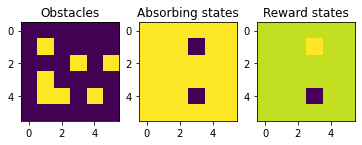

In [3]:
self = GridWorld(p = 0.65)

In [4]:
policy = np.ones((self.state_size,self.action_size)) / 4

In [5]:
def SARSA_Control(self,policy,discount,alpha,episodes):
    
    V_est = np.random.random(self.state_size) - 0.5
    V_est = np.zeros(self.state_size)
    absorbing_states = [self.loc_to_state(state_id,self.locs) for state_id in self.absorbing_locs]
    print(V_est)
    
    for j in range(episodes):
        
        trace = self.get_trace(policy)
        trace_len = len(trace)
        state_id = trace[0][0]
    
        for tripple_nr,tripple in enumerate(trace):
        
            if tripple_nr == trace_len - 1:
                break
                
                
            state_id,action,reward = tripple
            state_id_prime = trace[tripple_nr+1][0]
        
            delta = reward + discount * V_est[state_id_prime] - V_est[state_id]
            V_est[state_id] = V_est[state_id] + alpha * delta
    
    
    return V_est

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.]


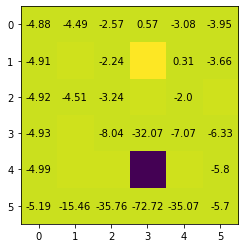

In [6]:
val = TDEstimation(self,policy,0.8,0.15)
self.draw_value(val)

In [26]:
self.get_trace(policy)

[(9, 0, -1.0),
 (4, 0, -1.0),
 (4, 0, -1.0),
 (4, 0, -1.0),
 (4, 0, -1.0),
 (4, 0, -1.0),
 (4, 0, -1.0),
 (4, 0, -1.0),
 (4, 0, -1.0),
 (4, 0, -1.0),
 (3, 0, -1.0),
 (3, 0, -1.0),
 (2, 0, -1.0),
 (3, 0, 10.0),
 (8, None, None)]